# stata_more

> Helper functions that expand on `pystata`/`sfi` functionality
- order: 3

For a diagram of the how the principal nbstata modules depend on this one, [click here](https://hugetim.github.io/nbstata/dev_docs_index.html).

In [ ]:
#| default_exp stata_more
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from nbstata.misc_utils import print_red
from nbstata.stata import run_direct, run_single, get_local, set_local, drop_var
from textwrap import dedent
import functools
from contextlib import redirect_stdout
from io import StringIO

In [ ]:
#| hide
#| eval: false
from nbstata.misc_utils import Timer
from nbstata.config import launch_stata

In [ ]:
#| hide
#| eval: false
launch_stata(splash=False)

## Simple Helpers

In [ ]:
#| export
def run_direct_cleaned(cmds, quietly=False, echo=False, inline=True):
    if quietly:
        with redirect_stdout(StringIO()) as diverted: # to prevent blank line output, as with `program define`
            out = run_direct(cmds, quietly, echo, inline)
            prints = diverted.getvalue()
        for line in prints.splitlines():
            if line.strip():
                print(line)
        return out
    elif len(cmds.splitlines()) > 1:
        with redirect_stdout(StringIO()) as diverted:
            run_direct(cmds, quietly, echo, inline)
            output_lines = diverted.getvalue().splitlines()
        if (len(output_lines) >= 2 
            and not output_lines[0].strip() 
            and "\n".join(output_lines[-2:]).strip() == "."):
            print("\n".join(output_lines[1:-2]))
        else:
            print("\n".join(output_lines))
    else:
        return run_direct(cmds, quietly, echo, inline)

`run_direct_cleaned` is a `run_direct`/`pystata.stata.run` wrapper function that removes extraneous blank lines from the output.

When given multi-line Stata code, `run_direct` outputs an extra blank line at the start and two extra lines at the end:

In [ ]:
#| eval: False
run_direct("""\
disp 1""", echo=True) # single-line Stata code

. disp 1
1


In [ ]:
#| eval: False
run_direct("""\
disp 1
disp 2""", echo=True) # multi-line Stata code


. disp 1
1

. disp 2
2

. 


We can clean it up like this:

In [ ]:
#| eval: False
with redirect_stdout(StringIO()) as diverted:
    run_direct(dedent("""\
        disp 1
        disp 2"""))
    output = diverted.getvalue()
print("\n".join(output.splitlines()[1:-2]))

. disp 1
1

. disp 2
2


In [ ]:
#| eval: False
run_direct_cleaned("""\
disp 1
disp 2""", echo=True)

. disp 1
1

. disp 2
2


In [ ]:
#| hide
#| eval: False
run_direct_cleaned("""\
disp 1
disp 2""", echo=False)

. disp 1
1

. disp 2
2


In [ ]:
#| hide
#| eval: False
run_direct_cleaned("""\
quietly {
    disp 2
}""", echo=False)

. quietly {


In [ ]:
#| hide
#| eval: False
run_direct_cleaned(dedent('''\
    python:
    print("hello")
    end
    '''), echo=False)

. python:
----------------------------------------------- python (type end to exit) -----
>>> print("hello")
hello
>>> end
-------------------------------------------------------------------------------


`run_direct_cleaned` also removes the blank line output by `run_direct` with `quietly=True`

In [ ]:
#| eval: False
prog_code = "program define _temp_prog \n disp 1 \n end"
run_direct(prog_code, quietly=True)

In [ ]:
#| eval: False
run_direct("capture program drop _temp_prog", quietly=True)
run_direct_cleaned(prog_code, quietly=True)

In [ ]:
#| hide
#| eval: False
code = dedent('''\
    python:
    do_nothin = 3
    end
    ''')
run_direct_cleaned(code, quietly=True)

#| hide
- But it does pass on any non-blank output by `run_direct` with `quietly=True`

In [ ]:
#| hide
#| eval: False
code = dedent('''\
    python:
    print("hello")
    end
    ''')
run_direct_cleaned(code, quietly=True)

hello


Note however that `run_direct_cleaned` delays text output until the code finishes running:

In [ ]:
#| eval: False
code = dedent('''\
    python:
    import time
    print(1)
    time.sleep(1)
    print(2)
    end
    ''')
run_direct(code, quietly=True)
run_direct_cleaned(code, quietly=True)

1
2

1
2


`run_direct_cleaned` may also misalign text output relative to graph output:

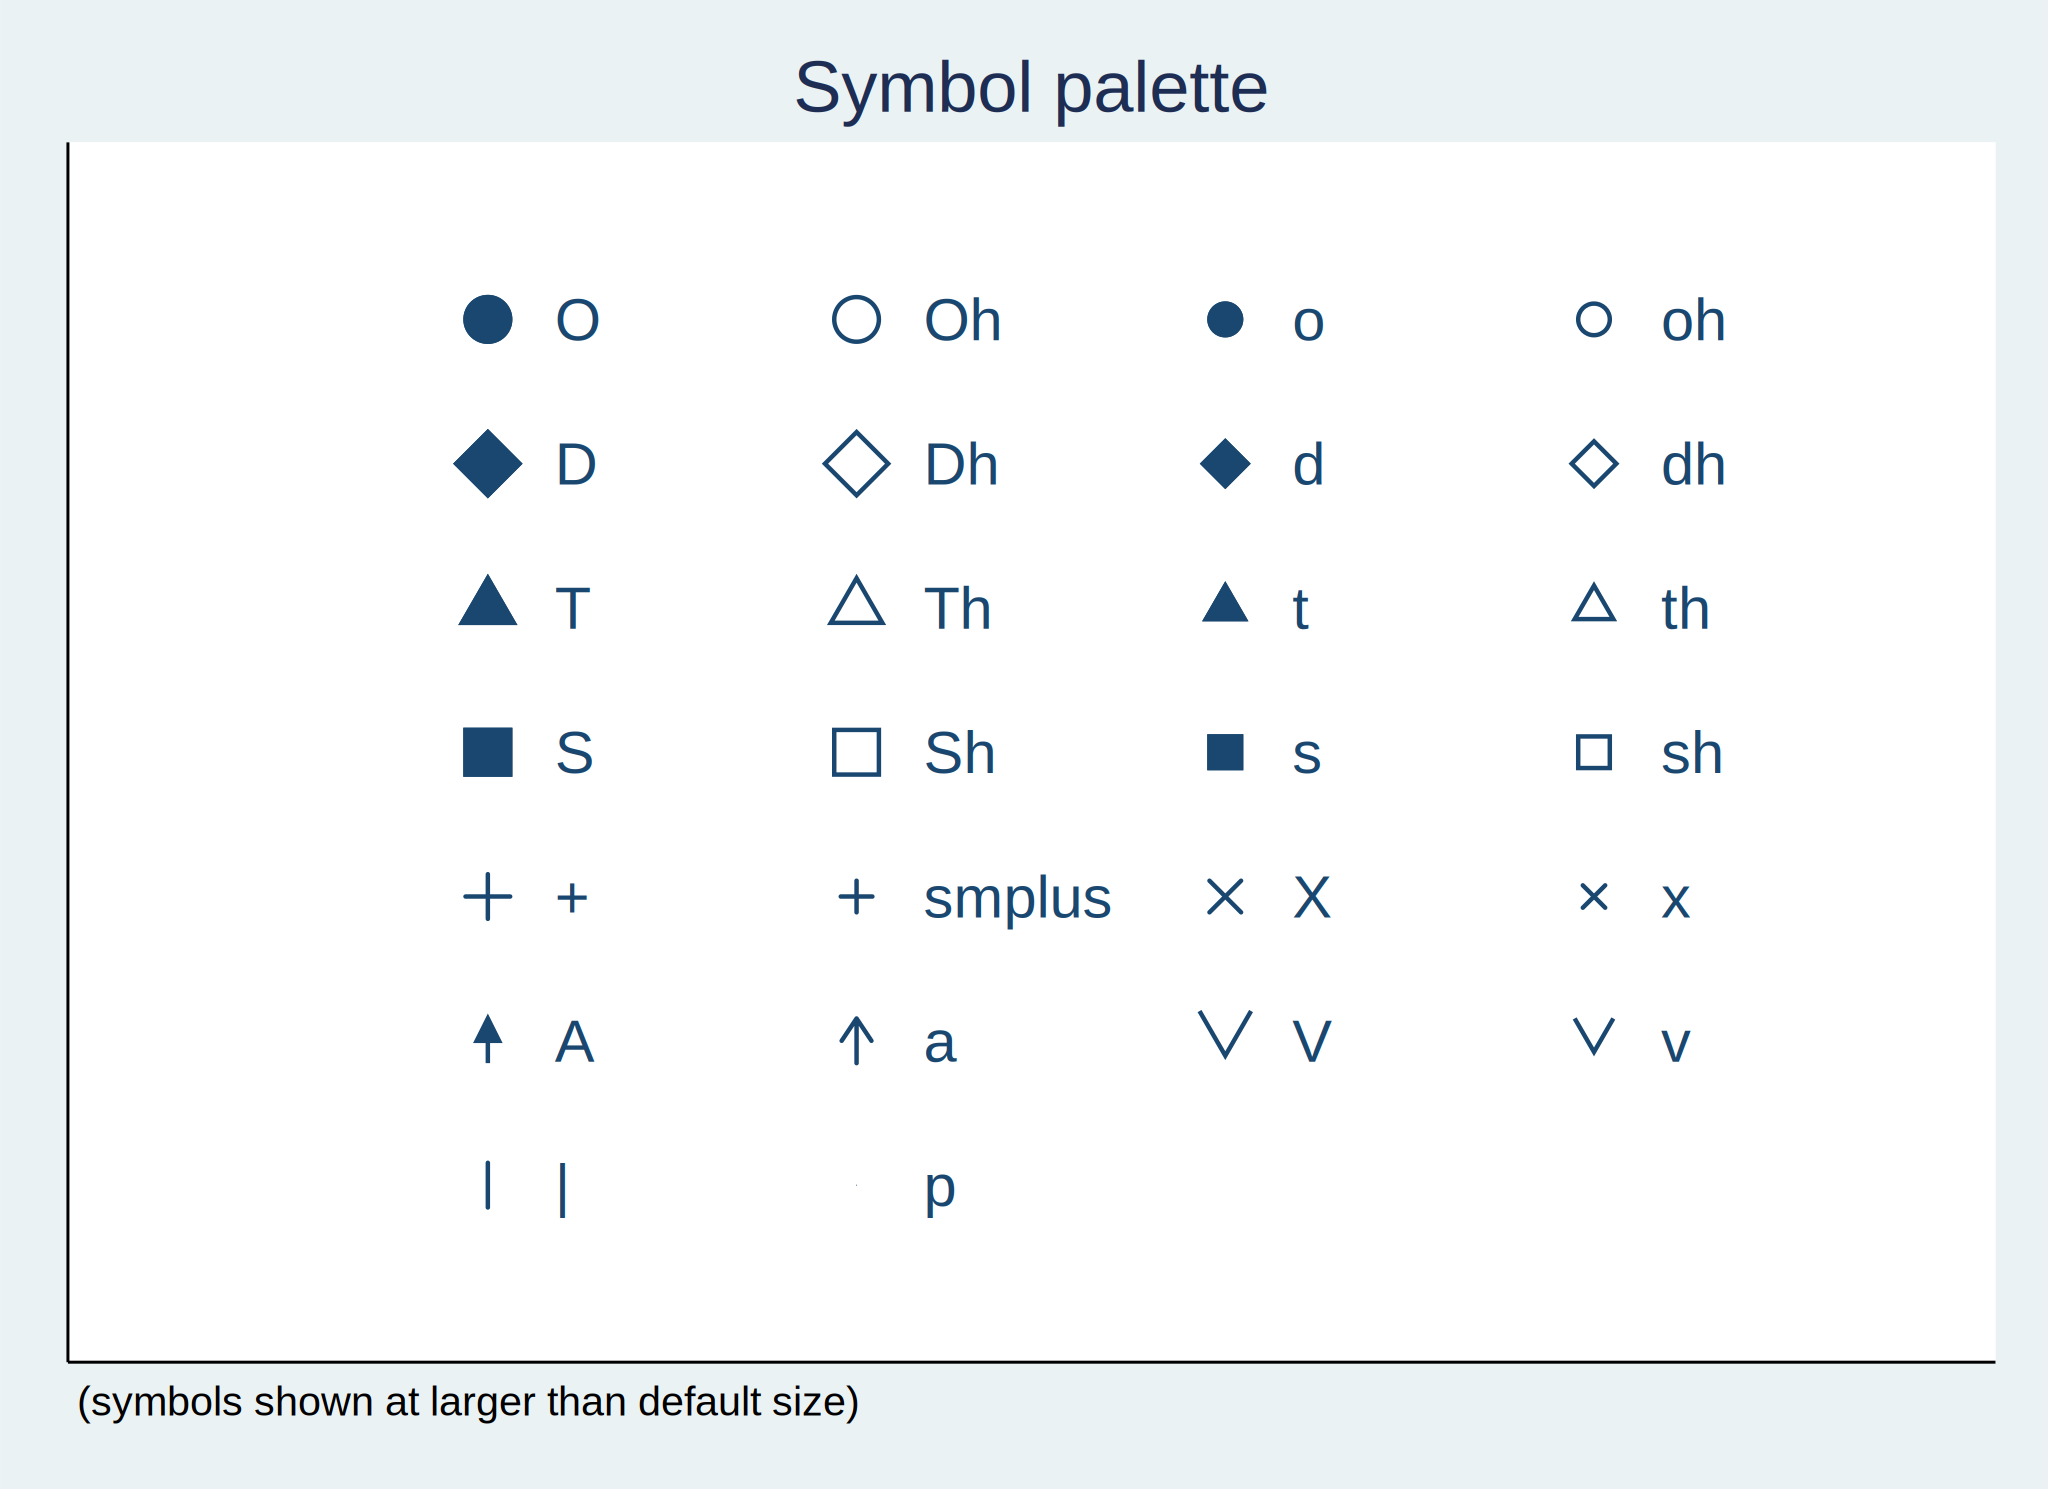

. disp "the problem arises with multi-line Stata code"
the problem arises with multi-line Stata code

. palette symbolpalette


In [ ]:
#| eval: False
run_direct_cleaned(dedent('''\
    disp "the problem arises with multi-line Stata code"
    palette symbolpalette'''), echo=True)

`run_sfi` should only be used for standardized code in which each line is a command suitable for the `sfi.SFIToolkit.stata` function. For such code, it provides much faster execution (with a `noecho` option). But it shares the limitations of `run_single`.

In [ ]:
#| export
def run_sfi(std_code, echo=False, show_exc_warning=True):
    import sfi
    cmds = std_code.splitlines()
    for i, cmd in enumerate(cmds):
        try:
            sfi.SFIToolkit.stata(cmd, echo)
        except Exception as e:
            if show_exc_warning:
                print_red(f"run_sfi (sfi.SFIToolkit.stata) error: {repr(e)}")
            remaining_code = "\n".join(cmds[i:])
            run_direct(remaining_code, echo=echo)
            break

In [ ]:
#| eval: false
run_sfi("""\
quietly set obs 5
quietly gen var1 = _n > 3
desc""")


Contains data
 Observations:             5                  
    Variables:             1                  
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
var1            float   %9.0g                 
-------------------------------------------------------------------------------
Sorted by: 
     Note: Dataset has changed since last saved.


In [ ]:
#| hide
from fastcore.test import test_eq, ExceptionExpected

In [ ]:
#| hide
#| eval: false
with ExceptionExpected(ex=SystemError):
    run_sfi(dedent("""\
        dip 1
        disp 2"""))

run_sfi (sfi.SFIToolkit.stata) error: SyntaxError('failed to execute the specified Stata command')


In [ ]:
#| hide
#| eval: false
run_sfi(dedent("""\
    disp 1
    disp 2"""))

1
2


In [ ]:
#| export
class SelectVar():
    """Class for generating Stata select_var for getAsDict"""
    varname = None
    
    def __init__(self, stata_if_code):
        import sfi
        condition = stata_if_code.replace('if ', '', 1).strip()
        if condition:
            self.varname = sfi.SFIToolkit.getTempName()
            cmd = f"quietly gen {self.varname} = cond({condition},1,0)"
            run_single(cmd, show_exc_warning=False)

    def clear(self):
        """Remove temporary select_var from Stata dataset"""
        if self.varname:
            drop_var(self.varname)
            
    def __enter__(self):
        return self.varname
    
    def __exit__(self, exc_type, exc_value, exc_tb):
        self.clear()

`Selectvar.varname` is a temporary Stata variable for use in `sfi.Data.getAsDict`

In [ ]:
#| eval: false
with SelectVar(" if var1==0") as sel_varname:
    print(f"varname: {sel_varname}")
    run_single("list, clean")
run_single("desc, simple")

varname: __000000

       var1   __000000  
  1.      0          1  
  2.      0          1  
  3.      0          1  
  4.      1          0  
  5.      1          0  
var1


In [ ]:
#| export
class IndexVar:
    """Class for generating Stata index var for use with pandas"""
    def __enter__(self):
        import sfi
        self.idx_var = sfi.SFIToolkit.getTempName()
        run_single(f"gen {self.idx_var} = _n", show_exc_warning=False)
        return self.idx_var
    
    def __exit__(self, exc_type, exc_value, exc_tb):
        drop_var(self.idx_var)

In [ ]:
#| eval: False
with Timer():
    with IndexVar() as idx_var:
        run_single("desc, simple")
    run_single("desc, simple")

var1      __000001
var1
Elapsed time: 0.0005 seconds


In [ ]:
#| hide
#| eval: false
import sfi

In [ ]:
#| hide
#| eval: false
test = sfi.SFIToolkit.getTempName()
test

'__000002'

## Run commands as a Stata program

The original motivation for adding this functionality is that `run_direct`/`pystata.stata.run` can only suppress the "echo" of single commands, not multi-line Stata code:

In [ ]:
#| eval: false
run_direct('disp "test 1"', echo=False)

test 1


In [ ]:
#| eval: false
two_lines_of_code = dedent('''\
    disp "test 1"
    disp "test 2"
    ''')
run_direct(two_lines_of_code, echo=False)


. disp "test 1"
test 1

. disp "test 2"
test 2

. 


As a workaround when echo is not desired, we can run multiple commands as a Stata program:

In [ ]:
#| eval: false
run_direct_cleaned(f"""\
program temp_nbstata_program_name
    {two_lines_of_code}
end""", quietly=True)

In [ ]:
#| eval: false
run_direct("temp_nbstata_program_name", quietly=False, inline=True, echo=False)

test 1
test 2


In [ ]:
#| eval: false
run_single(f"quietly program drop temp_nbstata_program_name")

(Note: This and the following two functions assume input Stata code standardized by `standardize_code`, which will be ensured by the `break_out_prog_blocks` within the ultimate `dispatch_run` wrapper function.)

In [ ]:
#| export
def run_as_program(std_non_prog_code, prog_def_option_code=""):
    _program_name = "temp_nbstata_program_name"
    _options = f", {prog_def_option_code}" if prog_def_option_code else ""
    _program_define_code = (
        f"program {_program_name}{_options}\n"
        f"{std_non_prog_code}\n"
        "end\n"
    )
    try:
        run_direct_cleaned(_program_define_code, quietly=True)
        run_direct(_program_name, quietly=False, inline=True, echo=False)
    finally:
        run_single(f"quietly program drop {_program_name}", show_exc_warning=False)

In [ ]:
#| eval: false
run_as_program(two_lines_of_code)

test 1
test 2


In [ ]:
#| hide
#| eval: false
run_as_program(two_lines_of_code, "sclass")

test 1
test 2


Not all code can be run within a program without modification, however: 
1. Programs cannot be defined within another program, nor can python or mata blocks be run.
2. A program definition is a different scope for locals, so:
    * the program code does not have access to locals defined previously, and
    * locals set within the program code do not persist outside of it.
    
(These issues are addressed by `run_noecho`.)

In [ ]:
#| eval: false
with ExceptionExpected(SystemError):
    run_as_program("""\
        program define prog1
            disp 1
        end
        """)

In [ ]:
#| eval: false
run_sfi('''\
local test1 = 1
disp "test1: `test1'" ''')

test1: 1


In [ ]:
#| eval: false
run_as_program("""\
    disp "test1: `test1'"
    local test2 = 2 """)

test1: 


In [ ]:
#| eval: false
run_sfi('''\
disp "test1: `test1'"
disp "test2: `test2'" ''')

test1: 1
test2: 


## Divert Stata output to string

The goal here is to get output from some Stata commands without changing the Stata environment. Three challenges arise:

1. Preserving `r()` return values requires special treatment because the `log on`/`off` commands needed to ensure this output is not logged are themselves r-class. 
2. The input `std_code` may also contain r-class commands. 
3. Capturing multi-line Stata output without the commands being echoed poses additional `run_as_program`-related challenges with regard to local variables.

To start, we set aside the latter two issues and simply use `run_direct` to run the Stata code. We handle the first issue by running the `log` commands inside an r-class program with [`return add`](https://www.stata.com/help.cgi?return) at the start.

A custom code `runner` may be specified. This may be useful if, for instance, the input `std_code` needs to access pre-existing `r()` results.

In [ ]:
#| export
def diverted_stata_output(std_code, runner=None):
    if runner is None:
        runner = functools.partial(run_direct, quietly=False, inline=True, echo=False)
    with redirect_stdout(StringIO()) as diverted:
        run_as_program("return add\ncapture log off", prog_def_option_code="rclass")
        try:
            runner(std_code)
        finally:
            run_as_program("return add\ncapture log on", prog_def_option_code="rclass")
        out = diverted.getvalue()
    return out

In [ ]:
from textwrap import dedent

In [ ]:
#| eval: false
two_lines_of_code = dedent('''\
    disp "test 1"
    disp "test 2"
    ''')
out = diverted_stata_output(two_lines_of_code)

In [ ]:
#| eval: false
print(out)


. disp "test 1"
test 1

. disp "test 2"
test 2

. 



In [ ]:
#| eval: false
print(diverted_stata_output('disp "test 1"', run_as_program))

test 1



If we know the code we're running is non-program code, we can get a speed improvement by running the `log` code together with the input `std_non_prog_code`.

In [ ]:
#| export
def diverted_stata_output_quicker(std_non_prog_code):
    with redirect_stdout(StringIO()) as diverted:
        code = f"return add\ncapture log off\n{std_non_prog_code}\ncapture log on"""
        try:
            run_as_program(code, prog_def_option_code="rclass")
        except SystemError as e:
            run_as_program("return add\ncapture log on", prog_def_option_code="rclass")
            raise(e)
        out = diverted.getvalue()
    return out

In [ ]:
#| eval: false
print(diverted_stata_output_quicker(two_lines_of_code))

test 1
test 2



In [ ]:
#| eval: false
with Timer():
    out1 = diverted_stata_output(two_lines_of_code, runner=run_sfi)
with Timer():
    out2 = diverted_stata_output_quicker(two_lines_of_code)
test_eq(out1, out2)

Elapsed time: 0.2083 seconds
Elapsed time: 0.0912 seconds


In [ ]:
#| hide
#| eval: false
with Timer():
    out3 = diverted_stata_output(two_lines_of_code, run_as_program)
test_eq(out1, out3)

Elapsed time: 0.3145 seconds


#| hide
## varlist utility

(not currently used) Takes a [Stata `varlist`](https://www.stata.com/help.cgi?varlist) and returns a list of full variable names, as required by [sfi.Data.getAsDict()](https://www.stata.com/python/api17/Data.html#sfi.Data.getAsDict). Frames (`strf`) not yet properly supported.

In [ ]:
#| hide
#| export
def var_from_varlist(varlist, stfr=None):
    if stfr:
        var_code = varlist.strip()
    else:
        _program_name = "temp_nbstata_varlist_name"
        run_direct_cleaned((
            f"program define {_program_name}\n"
            """ syntax [varlist(default=none)]
                foreach var in `varlist' {
                    disp "`var'"
                }
            end
            """), quietly=True)
        try:
            var_code = diverted_stata_output_quicker(f"""\
                {_program_name} {varlist}
                program drop {_program_name}
                """).strip()
        except Exception as e:
            run_single(f"capture program drop {_program_name}", show_exc_warning=True)
            raise(e)
    return [c.strip() for c in var_code.split() if c] if var_code else None

In [ ]:
#| hide
#| hide
_program_name = "temp_nbstata_varlist_name"
print(
            f"program define {_program_name}"
            """\            
                syntax [varlist(default=none)]
                foreach var in `varlist' {
                    disp "`var'"
                }
            end
            """)

program define temp_nbstata_varlist_name\            
                syntax [varlist(default=none)]
                foreach var in `varlist' {
                    disp "`var'"
                }
            end
            


In [ ]:
#| hide
#| hide
#| eval: False
run_sfi("""\
sum
return list""")


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
        var1 |          5          .4    .5477226          0          1

scalars:
                  r(N) =  5
              r(sum_w) =  5
               r(mean) =  .4
                r(Var) =  .3
                 r(sd) =  .5477225575051662
                r(min) =  0
                r(max) =  1
                r(sum) =  2


In [ ]:
#| hide
#| hide
#| eval: False
run_sfi("return list")


scalars:
                  r(N) =  5
              r(sum_w) =  5
               r(mean) =  .4
                r(Var) =  .3
                 r(sd) =  .5477225575051662
                r(min) =  0
                r(max) =  1
                r(sum) =  2


In [ ]:
#| hide
#| eval: False
print(var_from_varlist("v", None))

['var1']


In [ ]:
#| hide
#| hide
#| eval: False
run_sfi("return list")


scalars:
                r(sum) =  2
                r(max) =  1
                r(min) =  0
                 r(sd) =  .5477225575051662
                r(Var) =  .3
               r(mean) =  .4
              r(sum_w) =  5
                  r(N) =  5


In [ ]:
#| hide
#| eval: False
run_direct("""\
forval i = 2/20 {
    gen var`i' = var1
}""", quietly=True)
test_eq(var_from_varlist("v*", None),
        ['var1', 'var2', 'var3', 'var4', 
         'var5', 'var6', 'var7', 'var8', 
         'var9', 'var10', 'var11', 'var12', 
         'var13', 'var14', 'var15', 'var16', 
         'var17', 'var18', 'var19', 'var20'])

In [ ]:
#| hide
#| eval: False
run_sfi("drop var2-var20")

## Get local macro info

[https://www.statalist.org/forums/forum/general-stata-discussion/general/1457792-how-to-list-all-locals-and-store-them-in-a-macro](https://www.statalist.org/forums/forum/general-stata-discussion/general/1457792-how-to-list-all-locals-and-store-them-in-a-macro)

In [ ]:
#| export
def local_names():
    run_single("""\
        mata : st_local("temp_nbstata_all_locals", invtokens(st_dir("local", "macro", "*")'))""",
        show_exc_warning=False)
    out = get_local('temp_nbstata_all_locals')
    set_local('temp_nbstata_all_locals', "")
    return out.split()

In [ ]:
#| hide
def _local_names_old():
    out = diverted_stata_output("""mata : invtokens(st_dir("local", "macro", "*")')""")
#     run_direct("""\
#         mata : st_local("temp_nbstata_all_locals", invtokens(st_dir("local", "macro", "*")'))
#         """, quietly=True)
#     out = get_local('temp_nbstata_all_locals')
#     set_local('temp_nbstata_all_locals', "")
    return out.split()

In [ ]:
#| hide
#| eval: False
with Timer():
    local_names()
with Timer():
    _local_names_old()

Elapsed time: 0.0011 seconds
Elapsed time: 0.2424 seconds


In [ ]:
#| eval: False
run_sfi("""\
local test1 = 1
local test2 = 2""")
test_eq(set(local_names()), {'test1', 'test2'})

In [ ]:
#| export
def get_local_dict(_local_names=None):
    if _local_names is None:
        _local_names = local_names()
    return {n: get_local(n) for n in _local_names}

In [ ]:
#| eval: False
test_eq(get_local_dict(), {'test1': '1', 'test2': '2'})

In [ ]:
#| export
def locals_code_from_dict(preexisting_local_dict):
    local_defs = (f"""local {name} `"{preexisting_local_dict[name]}"'"""
                  for name in preexisting_local_dict)
    return "\n".join(local_defs)

In [ ]:
#| hide
print(locals_code_from_dict({'test1': 'blah', 'test2': 'blah blah'}))

local test1 `"blah"'
local test2 `"blah blah"'


In [ ]:
#| hide
test_eq(locals_code_from_dict({'test1': 'blah', 'test2': 'blah blah'}),
        """local test1 `"blah"\'\nlocal test2 `"blah blah"\'""")

In [ ]:
#| eval: False
print(locals_code_from_dict(get_local_dict()))

local test2 `"2"'
local test1 `"1"'


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()